In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

<h2>Training data preparation</h2>

The dataset created from the web crawler are imported as data frames. The target labels are added following by dropping the duplicates.<br> The datasets are subjected to random shuffling to reduce bias and variance.

In [2]:
trending = pd.read_csv(r"D:\Project\trending_news_prediction\trending_news.csv")
normal = pd.read_csv(r"D:\Project\trending_news_prediction\non_trending_news.csv")
test = pd.read_csv(r"D:\Project\trending_news_prediction\test.csv")

In [3]:
#Adding a target column to identify the trending news
#trending = 1, non_trending = 0
trending["target"] = 1
normal["target"] = 0

In [4]:
#training dataset
train=pd.concat([trending,normal],axis=0)

In [5]:
#drop duplicates
train.drop_duplicates(subset='desc',keep='first',inplace=True)
test.drop_duplicates(subset='desc',keep='first',inplace=True)

In [6]:
train["target"].value_counts()

1    250
0    207
Name: target, dtype: int64

In [7]:
#shuffling
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [8]:
train.head()

,title,desc,target
0,MS Dhoni vs Andrew Flintoff: Throwback! MS Dho...,MS Dhoni had responded in an epic manner after...,1
1,Rise With India: Top stories to watch out for ...,Here are top 10 new stories that you must know...,0
2,Sundar Pchai plays cricket: 'Always love a cha...,Google CEO Sundar Pichai is a huge cricket fan...,0
3,FIR against Punjab MLA Simarjit Bains on rape ...,This comes days after&nbsp;a Punjab court here...,1
4,Solar storm today | Powerful solar storm headi...,Besides the communication infrastructure on Ea...,1


In [9]:
test.head()

,title,desc
0,Hyderabad: 34-year-old man who targeted lone l...,"Hyderabad News: As per reports, when the drive..."
1,From Amala Paul to Sameera Reddy: South actres...,"In recent times though, there has been increas..."
2,Physical activity may counter serious health h...,A recent study suggests that people with the p...
3,UPSC Topper Story: Daily wage earner's son Sat...,UPSC Topper story inspire aspirants. Satheesh ...
4,Wimbledon: Barbora Krejcikova sets up fourth-r...,Barbora will take on world No. 1 Ashleigh Bart...


<h2>Sanitizing the datasets</h2>

The nltk module is used to ensure stopwords such as "the,a,an,is.." are removed along with special characters.

In [10]:
#Cleaning description data using nltk module
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('punkt')

def sanitize(in_column):
    sanitized = []
    for line in in_column:
        only_letters = re.sub("[^a-zA-Z0-9]", " ",line) 
        tokens = nltk.word_tokenize(only_letters)
        lower_case = [l.lower() for l in tokens]
        filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
        lemmas = ' '.join([wordnet_lemmatizer.lemmatize(t) for t in filtered_result])
        sanitized.append(lemmas)
    return sanitized        

train["desc"] = sanitize(train["desc"])
test["desc"] = sanitize(test["desc"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kraks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kraks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kraks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h2>Document-Term Matrix</h2>

A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.<br><br>
We combine the train and test datasets to obtain a DTM which is used for Exploratory data analysis.

In [11]:
#variable for train-test split
y=train["target"]

In [12]:
a=train.shape[0]
combined=pd.concat([train,test],axis=0).reset_index(drop=True)
def dtm(textcol):
    cv = CountVectorizer(stop_words='english')
    data_cv = cv.fit_transform(textcol)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = textcol.index
    return data_dtm

combined_dtm=dtm(combined["desc"])

In [13]:
#the combined DTM includes both train & test sets(457+20=477 records)
combined_dtm

,00,000,00am,020,03,05,06,10,100,107,...,younger,youngster,youth,yuvraj,yuzvendra,zealand,zika,zomato,zone,zydus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>Exploratory Data Analysis</h2>

1) We check the top single words repeating in the dataset.<br>
2) Build a wordcloud for the same.<br>
3) We check the top bi-gram(two word) words repeating in the dataset.

[Text(0, 0, '2021'),
 Text(1, 0, 'said'),
 Text(2, 0, 'july'),
 Text(3, 0, 'india'),
 Text(4, 0, 'year'),
 Text(5, 0, 'nbsp'),
 Text(6, 0, 'day'),
 Text(7, 0, 'minister'),
 Text(8, 0, 'england'),
 Text(9, 0, 'state'),
 Text(10, 0, 'pradesh'),
 Text(11, 0, 'quot'),
 Text(12, 0, 'government'),
 Text(13, 0, 'check'),
 Text(14, 0, 'police'),
 Text(15, 0, 'also'),
 Text(16, 0, 'covid'),
 Text(17, 0, 'former'),
 Text(18, 0, '19'),
 Text(19, 0, 'two')]

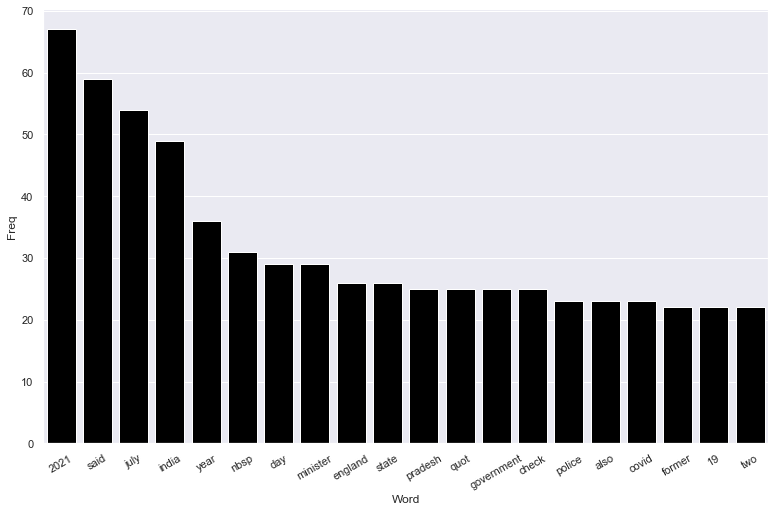

In [14]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(train['desc'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df,color='Black')
g.set_xticklabels(g.get_xticklabels(), rotation=30)

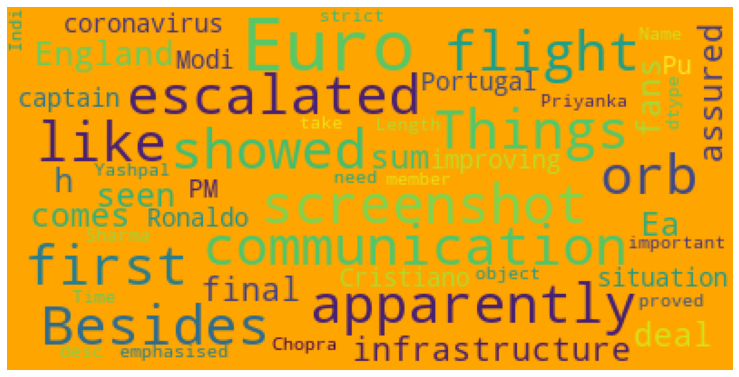

In [15]:
wordcloud = WordCloud(    background_color='Orange', stopwords=stop_words, max_words=100, max_font_size=40, random_state=42).generate(str(trending["desc"]))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

[Text(0, 0, 'covid 19'),
 Text(1, 0, 'euro 2020'),
 Text(2, 0, 'july 13'),
 Text(3, 0, 'uttar pradesh'),
 Text(4, 0, 'year old'),
 Text(5, 0, 'july 12'),
 Text(6, 0, 'yashpal sharma'),
 Text(7, 0, 'result 2021'),
 Text(8, 0, 'former indian'),
 Text(9, 0, 'world cup'),
 Text(10, 0, 'official website'),
 Text(11, 0, 'social medium'),
 Text(12, 0, 'chief minister'),
 Text(13, 0, 'west indie'),
 Text(14, 0, '12 2021'),
 Text(15, 0, 'tamil nadu'),
 Text(16, 0, 'today july'),
 Text(17, 0, 'admit card'),
 Text(18, 0, 'official site'),
 Text(19, 0, 'check detail')]

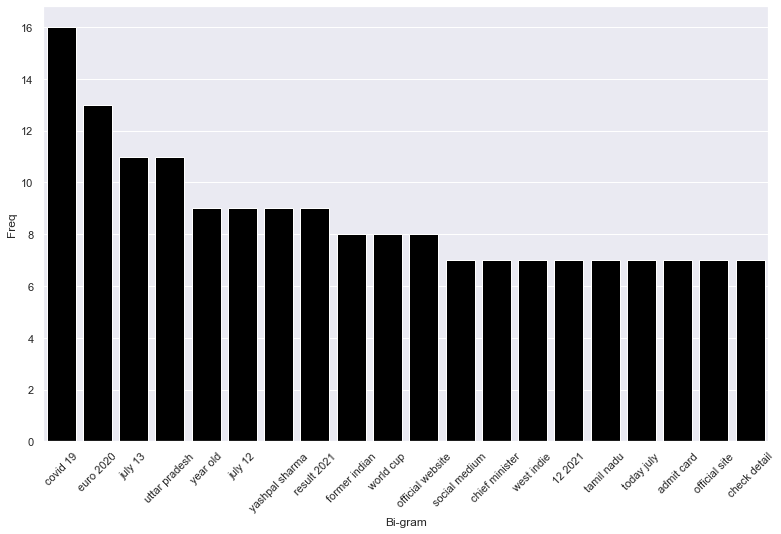

In [16]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(train["desc"] ,n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df,color="black")
h.set_xticklabels(h.get_xticklabels(), rotation=45)

<h2>Train & Test Dataset Split</h2>

In [17]:
train_dtm=combined_dtm.iloc[:a,:]
test_dtm=combined_dtm.iloc[a:,:]

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_dtm,y, test_size=0.2,random_state=0)

<h2>Comparing the Following Machine Learning models for the use case</h2>

1) LogisticRegression<br>
2) KNeighborsClassifier<br>
3) DecisionTreeClassifier<br>
4) RandomForestClassifier<br>
5) XGBClassifier

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

C:\Users\kraks\anaconda3\envs\projects\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:58:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

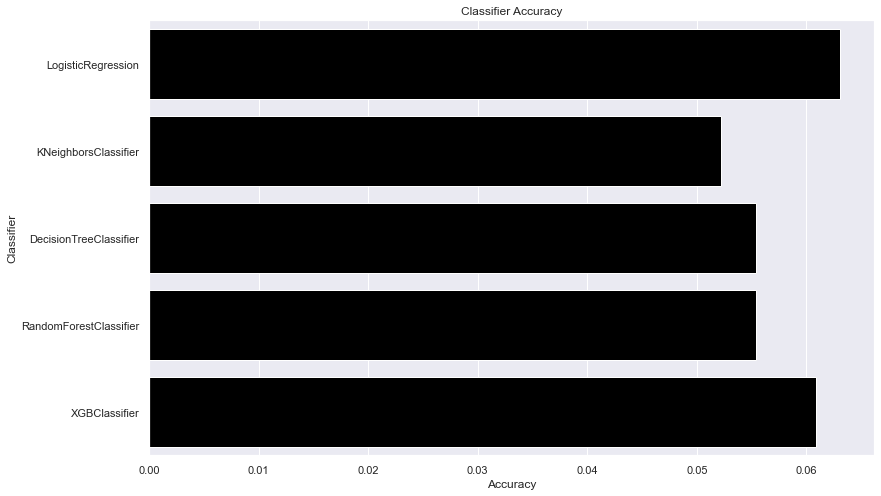

In [20]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="black")

In [21]:
#Choosing LogisticRegression Model since its has a higer accuracy
lrc=LogisticRegression()
lrc.fit(X_train,y_train)
y_pred=lrc.predict(X_test)

In [22]:
#Confusin matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
cm

array([[22, 23],
       [11, 36]], dtype=int64)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6304347826086957

<h2>Predicting the target variable for the test dataset</h2>

In [24]:
y_pred_test=lrc.predict(test_dtm)

In [25]:
test["target"]=y_pred_test
test.drop("desc",axis=1,inplace=True)
test

,title,target
0,Hyderabad: 34-year-old man who targeted lone l...,1
1,From Amala Paul to Sameera Reddy: South actres...,1
2,Physical activity may counter serious health h...,1
3,UPSC Topper Story: Daily wage earner's son Sat...,1
4,Wimbledon: Barbora Krejcikova sets up fourth-r...,1
5,"India logs 43,071 fresh COVID-19 cases | India...",1
6,Govt imposes stock limits on pulses till Oct t...,1
7,Risk factors for severe COVID-19 in individual...,1
8,"Aamir-Kiran divorce | Aamir Khan, Kiran Rao ho...",0
9,Handshake Viral Meme Twitter| What is 'handsha...,1


<h2>Inferences</h2>

1) From the results, we can observe that the any news related to COVID-19 is tagged as Trending which is true considering the pandemic.<br>
2) Another observation from the prediction table is that the word **Viral** (or **Trending**) in the title also contributes a lot for news article to trend on social media or news websites.<br>
3) Cricket sport in India has huge following which is also reflected in prediction table.